# Lab3a
# What is Xarray?

Xarray extends the capabilities of NumPy by providing a data structure for labeled, multi-dimensional arrays. The two main data structures in Xarray are:

- **DataArray**: A labeled, multi-dimensional array, which includes dimensions, coordinates, and attributes.
- **Dataset**: A collection of `DataArray` objects that share the same dimensions.

![](https://docs.xarray.dev/en/stable/_images/dataset-diagram.png)

Xarray is particularly useful for working with datasets where dimensions have meaningful labels (e.g., time, latitude, longitude) and where metadata is important.

* `rasterio`: The main library for reading and writing raster data.
* `rasterio.plot`: A submodule of Rasterio for plotting raster data.
* `numpy`: A powerful library for array manipulations, which is very useful for raster data.
* `matplotlib`: A standard plotting library in Python for creating visualizations.

In [ ]:
# %pip install xarray 

In [1]:
import xarray as xr
# This imports the pyplot module from matplotlib, a plotting library that provides functions for making a variety visualizations in Python.
import matplotlib.pyplot as plt



c:\Users\C00553090\AppData\Local\miniconda3\envs\hypercoast\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Path to your Sentinel-2 NetCDF image
nc_file_path = './S2A_MSI_2016_09_20_16_44_50_T15RYN_L2W_subset.nc'

# Open the NetCDF file，this line uses xarray's open_dataset function to load the NetCDF file specified by nc_file_path into the variable ds. 
# The ds variable now contains an xarray.Dataset object, which is a multi-dimensional, in-memory array database. 
# Rhis dataset likely contains various data variables such as spectral bands and other metadata.

ds = xr.open_dataset(nc_file_path)

# Check available variables (bands) in the dataset
print("Variables in the dataset:", ds.data_vars)

Variables in the dataset: Data variables:
    Rrs_443             (y, x) float32 175MB ...
    Rrs_492             (y, x) float32 175MB ...
    Rrs_560             (y, x) float32 175MB ...
    Rrs_665             (y, x) float32 175MB ...
    Rrs_704             (y, x) float32 175MB ...
    Rrs_740             (y, x) float32 175MB ...
    Rrs_783             (y, x) float32 175MB ...
    Rrs_833             (y, x) float32 175MB ...
    Rrs_865             (y, x) float32 175MB ...
    Rrs_1614            (y, x) float32 175MB ...
    Rrs_2202            (y, x) float32 175MB ...
    l2_flags            (y, x) int32 175MB ...
    chl_oc3             (y, x) float32 175MB ...
    chl_re_mishra       (y, x) float32 175MB ...
    SPM_Nechad2016_665  (y, x) float32 175MB ...


In [3]:
# Extract the necessary variables (TSS and Rrs_665)

red = ds['Rrs_665'].values
green = ds['Rrs_560'].values
NIR1 = ds['Rrs_704'].values
NIR2 = ds['Rrs_740'].values
NIR3 = ds['Rrs_833'].values
# Make sure lon and lat are 1D arrays
lon = ds['lon'].values
lat = ds['lat'].values

# Calculate TSS using the formula (Miller & McKee, 2004)
# https://www.sciencedirect.com/science/article/pii/S0034425704002317
TSS_Miller = 1140.25 * red - 1.91

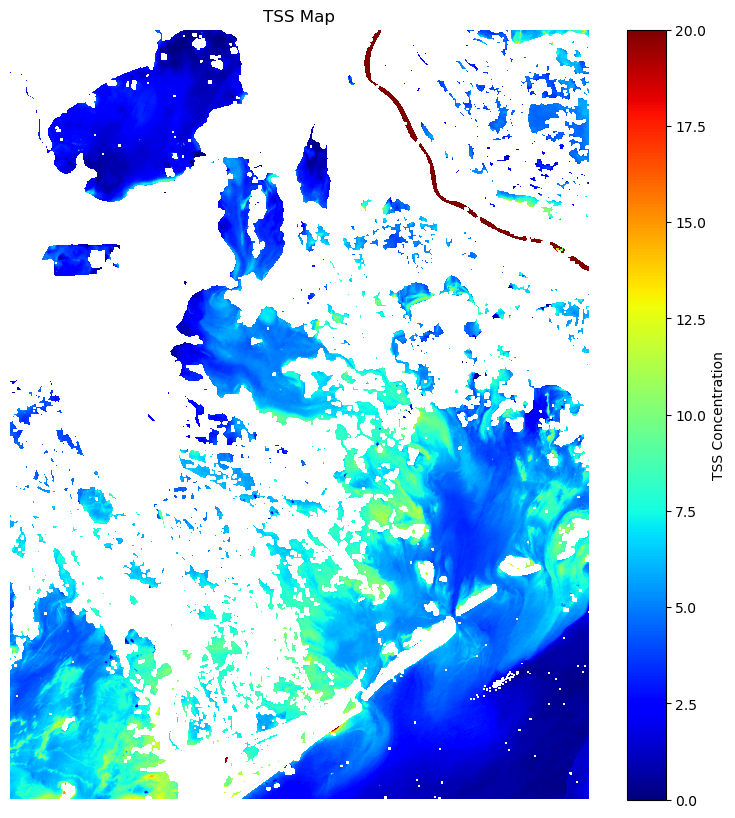

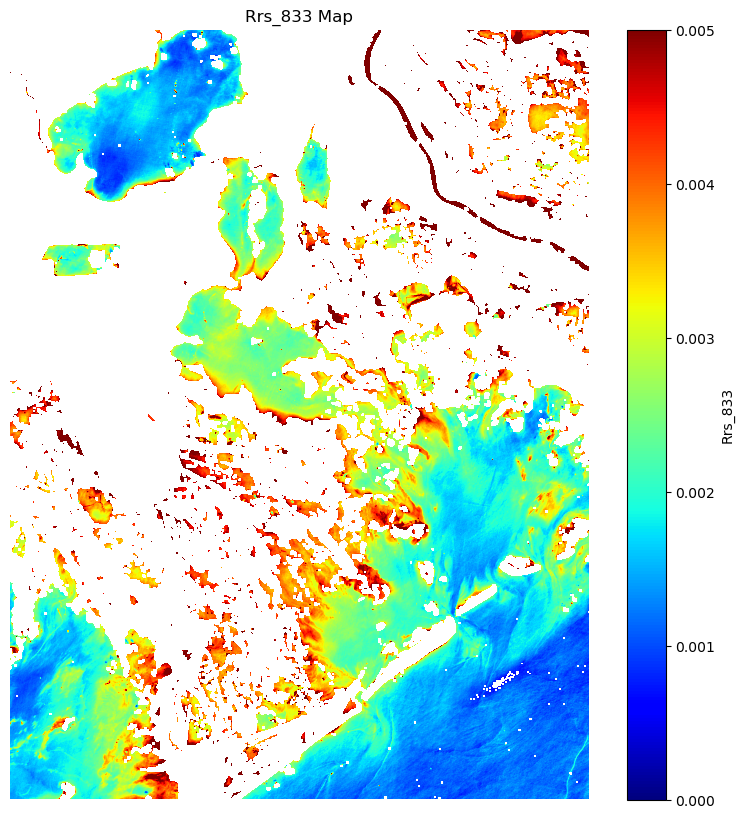

In [4]:
# Optional: Display the TSS map
plt.figure(figsize=(10, 10))
plt.imshow(TSS_Miller, cmap='jet', vmin=0, vmax=20)
plt.colorbar(label='TSS Concentration')
plt.title('TSS Map')
plt.axis('off')
plt.show()

# Optional: Display the Rrs_665 map
plt.figure(figsize=(10, 10))
plt.imshow(NIR3, cmap='jet', vmin=0, vmax=0.005)  # You can choose a different colormap
plt.colorbar(label='Rrs_833')
plt.title('Rrs_833 Map')
plt.axis('off')
plt.show()

## Reading Raster Data

To read raster data, you can use the `rasterio.open()` function. This function creates a connection to the file without loading the entire dataset into memory. This is particularly useful for large datasets like satellite imagery or high-resolution DEMs, as they might be too big to fit into memory at once.

In [9]:
import rasterio
import rasterio.plot
from rasterio.transform import from_origin

# Create transform using top-left corner (lon.min(), lat.max()) and pixel size

# The from_origin(lon.min(), lat.max(), pixel_size_x, pixel_size_y) function creates a transformation matrix that starts at the top-left corner 
# of the image (where lon.min() and lat.max() are) and applies the pixel sizes to convert the image into a geospatial format that software 
# like QGIS, ArcGIS, or any other GIS tool can interpret.
# The transform provides a way to map between pixel coordinates (like row/column in an array) and real-world coordinates (latitude/longitude). 
# Without this, the image would not be tied to any specific place on Earth.

pixel_size_x = (lon.max() - lon.min()) / red.shape[1]
pixel_size_y = (lat.max() - lat.min()) / red.shape[0]
transform = from_origin(lon.min(), lat.max(), pixel_size_x, pixel_size_y)

# Define the output GeoTIFF filename
output_tif = 'TSS_and_Rrs_12082015_lab1.tif'


# Save both the TSS concentration and Rrs as bands in the GeoTIFF
# The rasterio.open function is used here with the 'w' option to open a file for writing:
with rasterio.open(
    output_tif,
    'w',
    driver='GTiff',
    height=TSS_Miller.shape[0],
    width=TSS_Miller.shape[1],
    count=6,  # Two bands: one for TSS and one for Rrs_665
    dtype=TSS_Miller.dtype,  # Assuming both have the same data type
    crs='EPSG:4326',
    transform=transform,
) as dst:
    # Writing Data to the GeoTIFF within the opened file context (dst), multiple data arrays are written to different bands of the GeoTIFF:
    dst.write(TSS_Miller, 1)  # Write TSS concentration to the first band
    dst.write(red, 2)  # Write Rrs_665 to the second band
    dst.write(green, 3) # 
    dst.write(NIR1, 4)  # 
    dst.write(NIR2, 5)  # 
    dst.write(NIR3, 6)  #

print(f'Saved {output_tif}')

Saved TSS_and_Rrs_12082015_lab1.tif


In [10]:
raster_path = './TSS_and_Rrs_12082015_lab.tif'
src = rasterio.open(raster_path)
print(src)

<open DatasetReader name='./TSS_and_Rrs_12082015_lab.tif' mode='r'>


File Name: The name attribute gives you the file path or URL of the opened raster.

In [ ]:
src.name

File Mode: The mode attribute shows how the file was opened. For example, a raster can be opened in read-only ('r') or write ('w') mode.

In [ ]:
src.mode

Raster Metadata: The meta attribute provides key information about the raster, such as its width, height, CRS, number of bands, and data type.

In [ ]:
src.meta

The CRS describes how the 2D pixel values relate to real-world geographic coordinates (latitude and longitude or projected coordinates). Knowing the CRS is essential for interpreting the data in a meaningful way. To retrieve the CRS:

In [ ]:
src.crs